Loaded pretrained model gpt2-small into HookedTransformer


  2%|▏         | 998/47027 [01:30<54:59, 13.95it/s]  

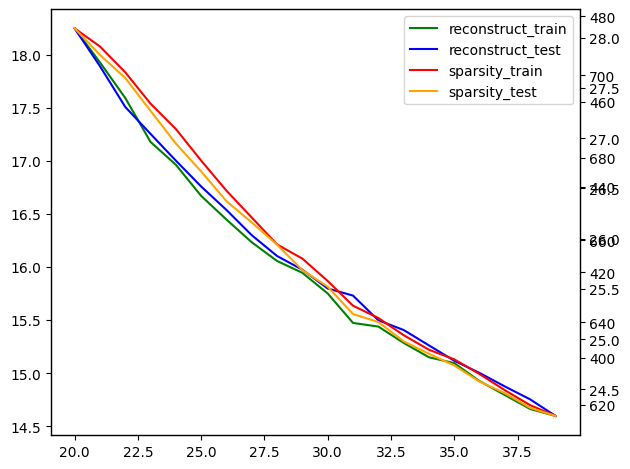

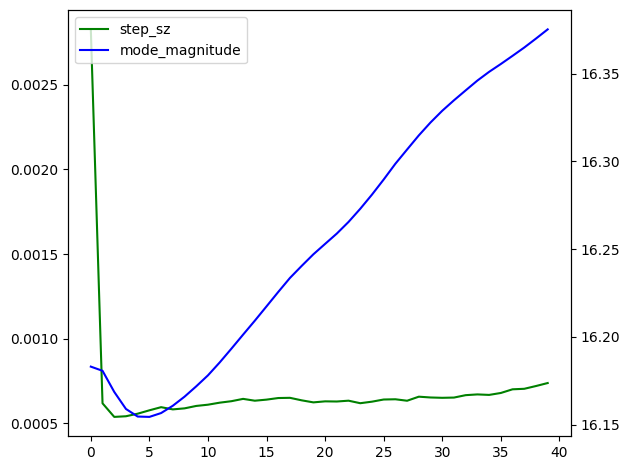

  4%|▍         | 1998/47027 [03:03<53:54, 13.92it/s]  

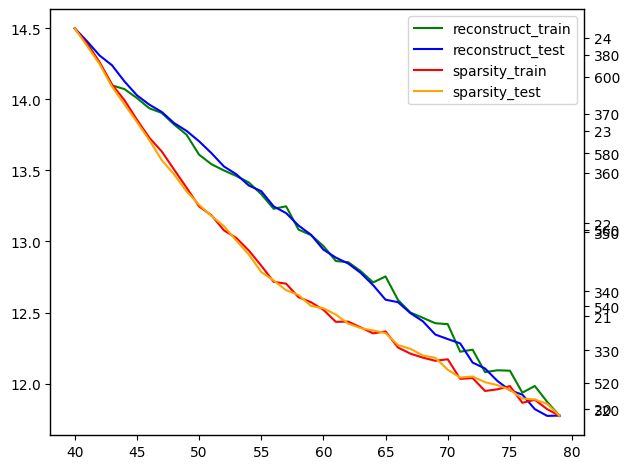

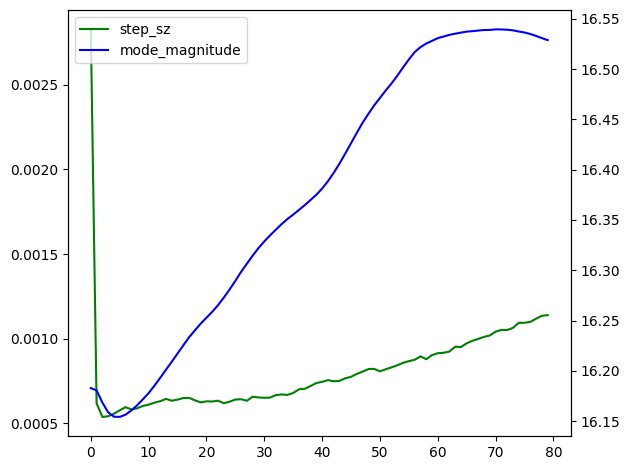

  6%|▋         | 2998/47027 [04:36<52:37, 13.94it/s]  

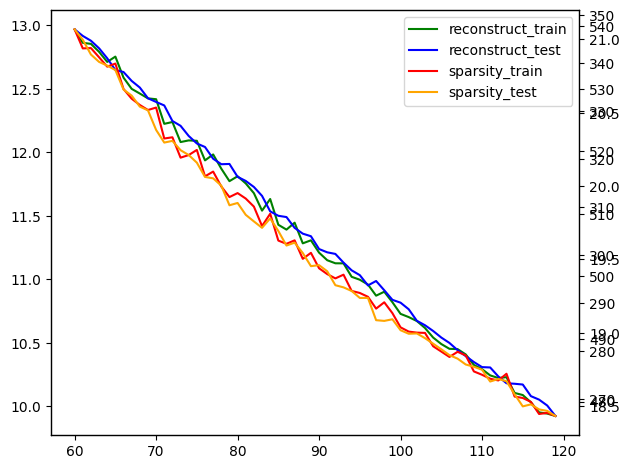

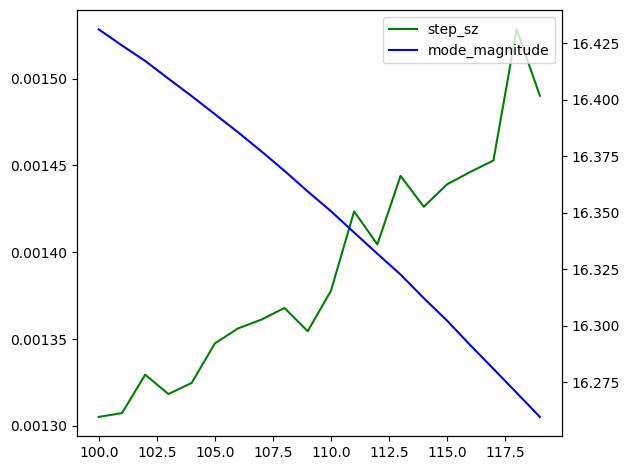

  9%|▊         | 3998/47027 [06:08<51:20, 13.97it/s]  

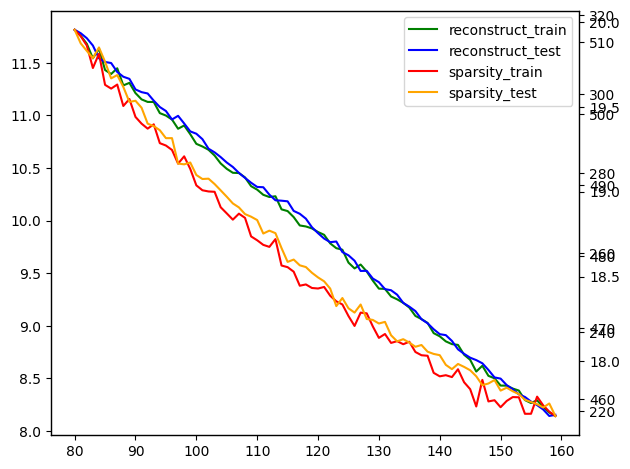

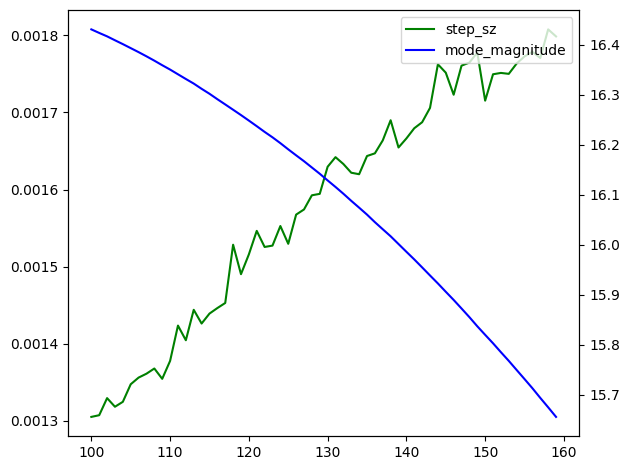

 11%|█         | 4998/47027 [07:41<49:50, 14.05it/s]  

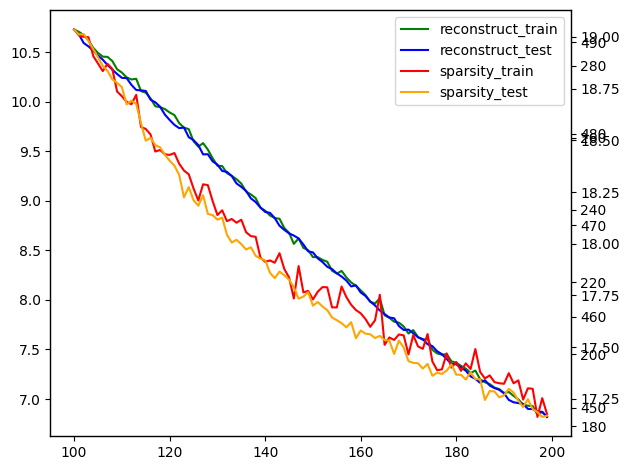

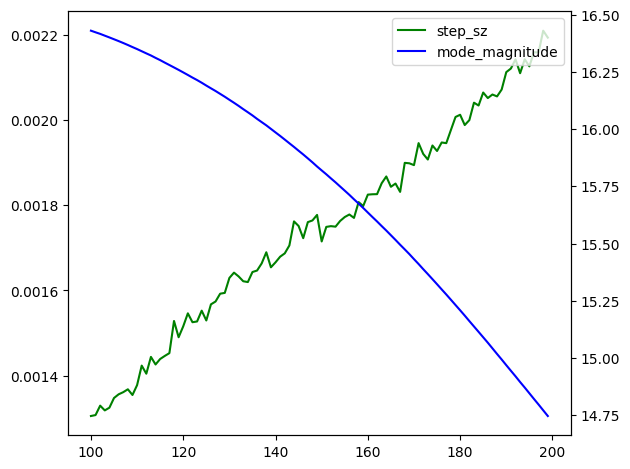

 13%|█▎        | 5998/47027 [09:13<48:39, 14.05it/s]  

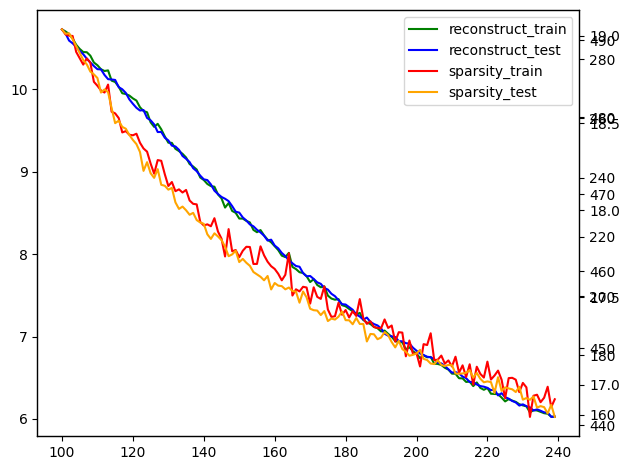

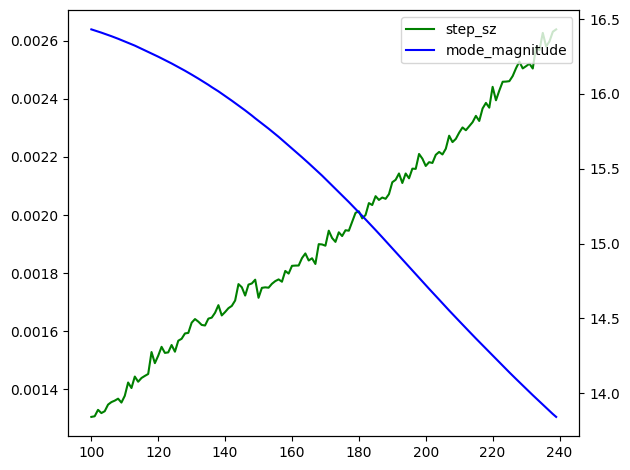

 15%|█▍        | 6998/47027 [10:46<47:38, 14.00it/s]  

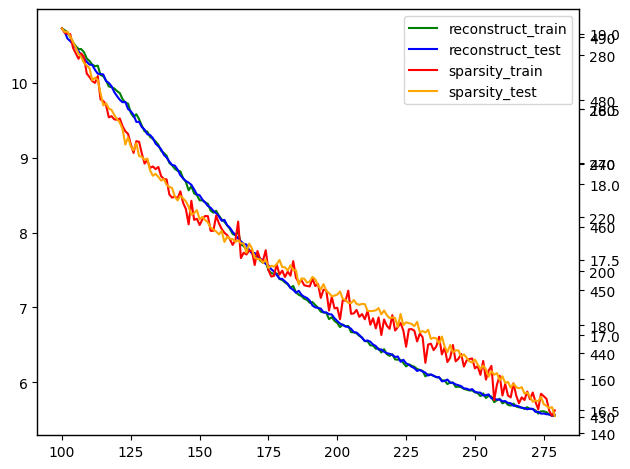

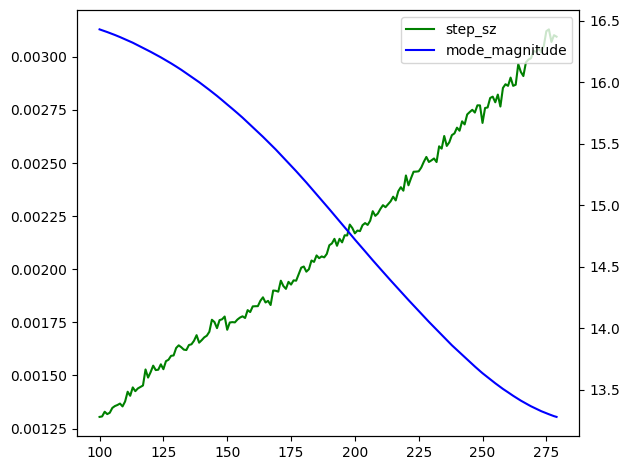

 17%|█▋        | 7998/47027 [12:19<46:07, 14.11it/s]  

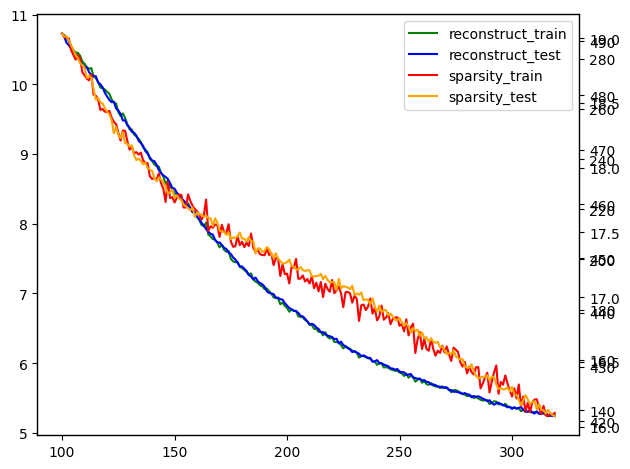

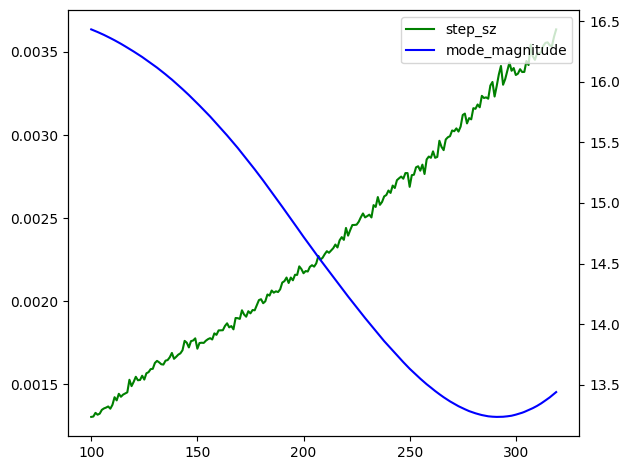

 19%|█▉        | 8998/47027 [13:51<45:11, 14.02it/s]  

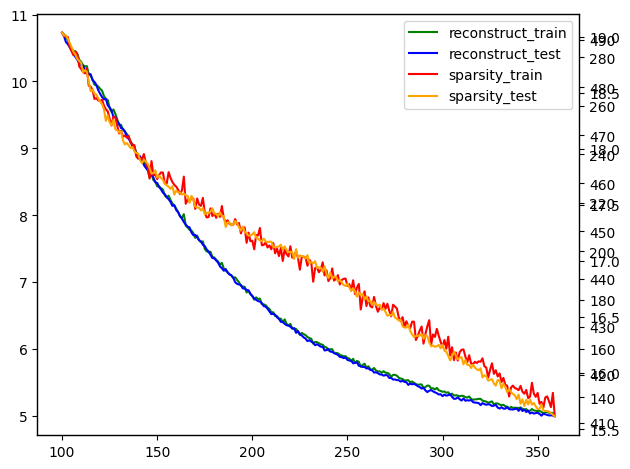

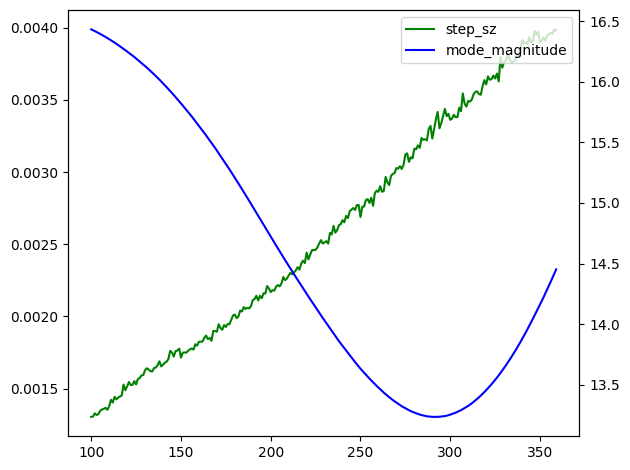

 21%|██▏       | 9998/47027 [15:24<44:07, 13.99it/s]  

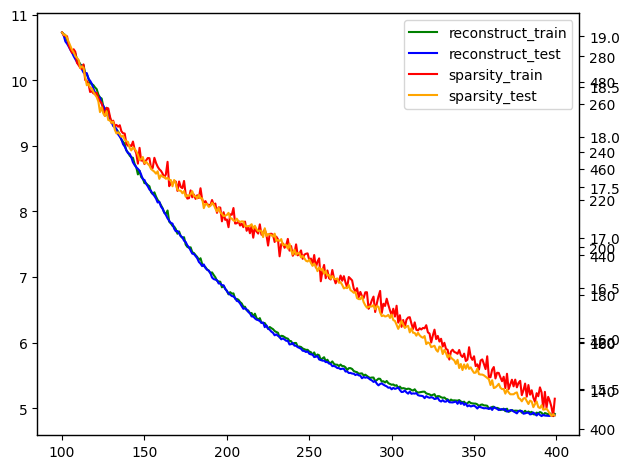

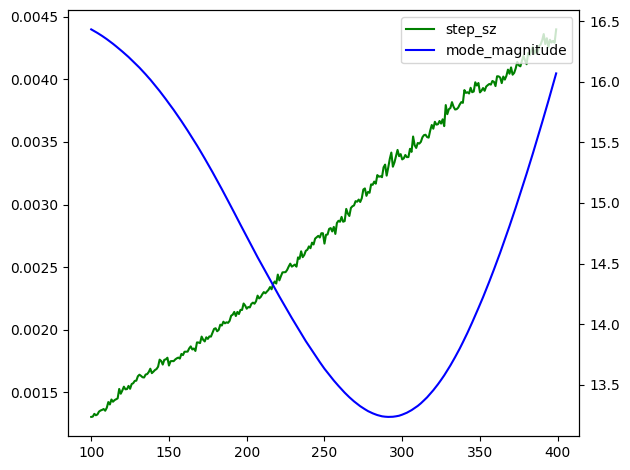

 23%|██▎       | 10998/47027 [16:56<42:45, 14.04it/s]  

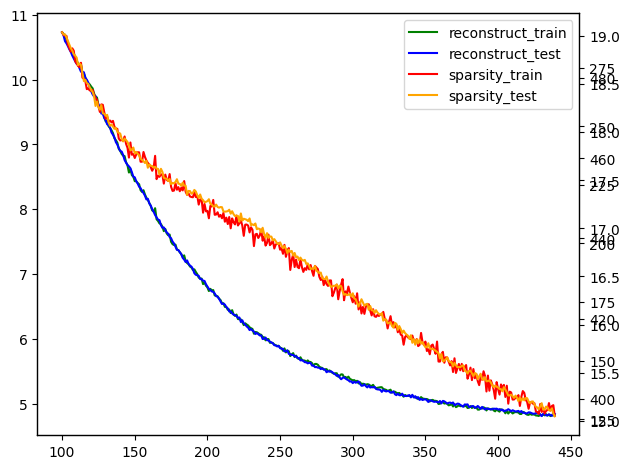

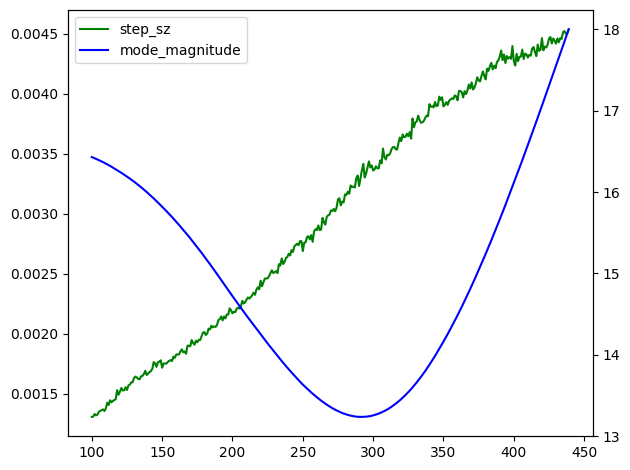

 26%|██▌       | 11998/47027 [18:28<41:50, 13.96it/s]  

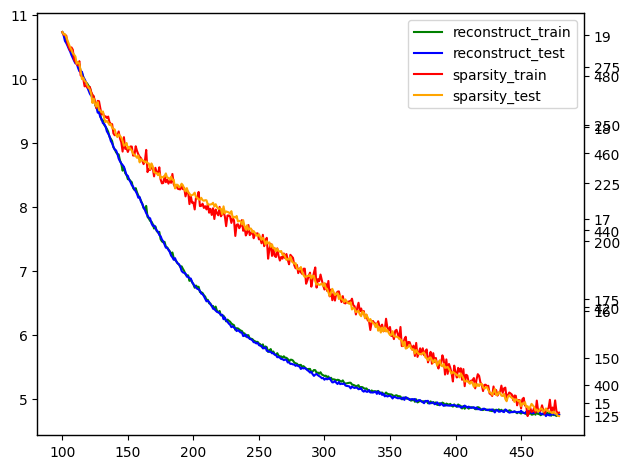

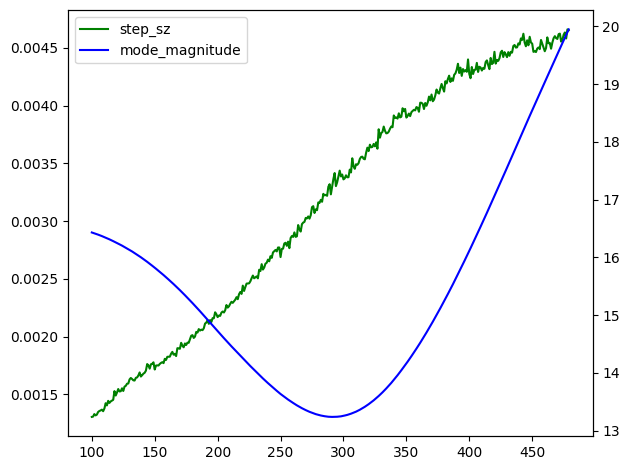

 28%|██▊       | 12998/47027 [20:01<40:21, 14.05it/s]  

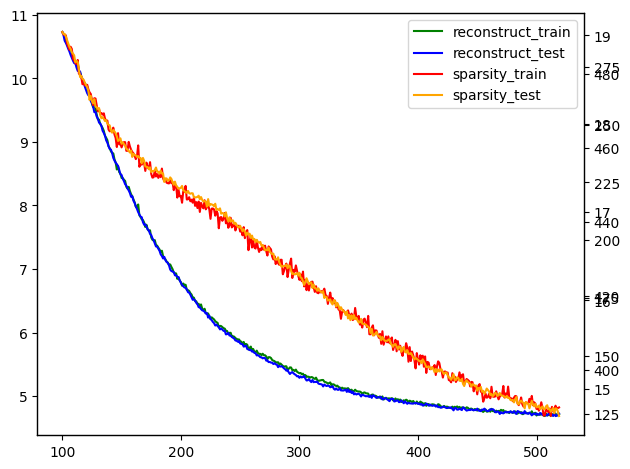

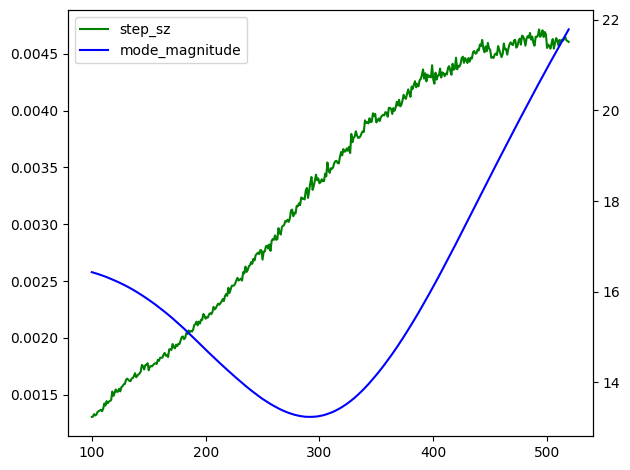

 30%|██▉       | 13998/47027 [21:33<39:13, 14.03it/s]  

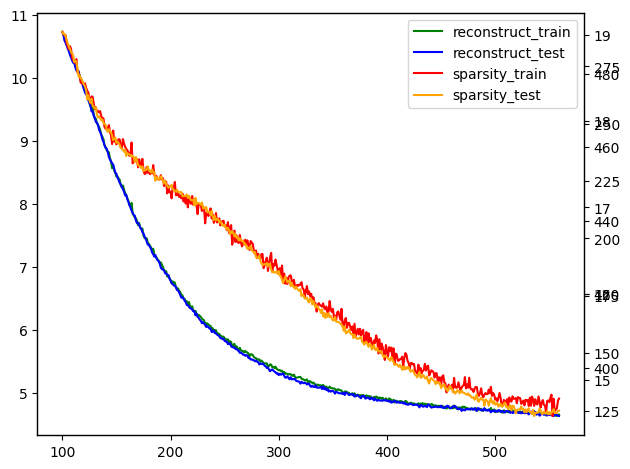

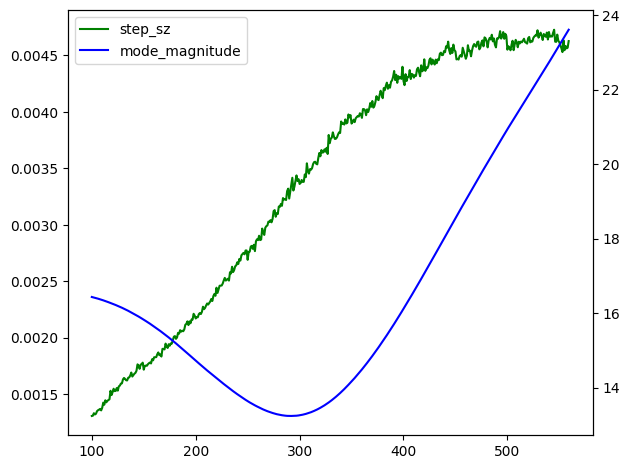

 32%|███▏      | 14998/47027 [23:07<38:19, 13.93it/s]  

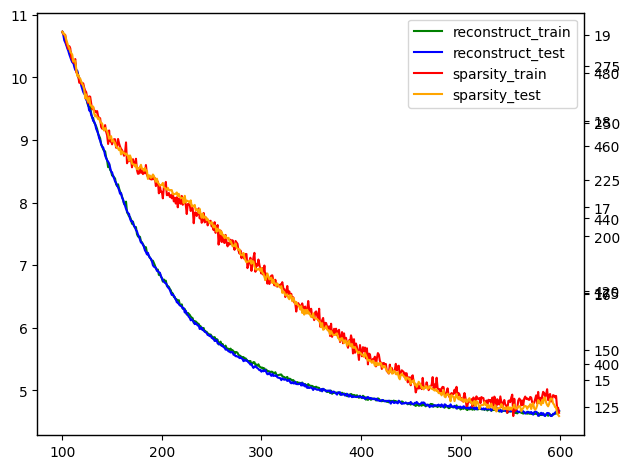

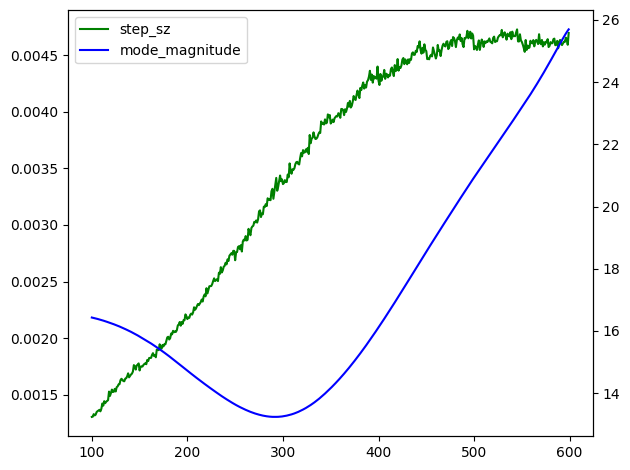

 34%|███▍      | 15998/47027 [24:40<36:58, 13.98it/s]  

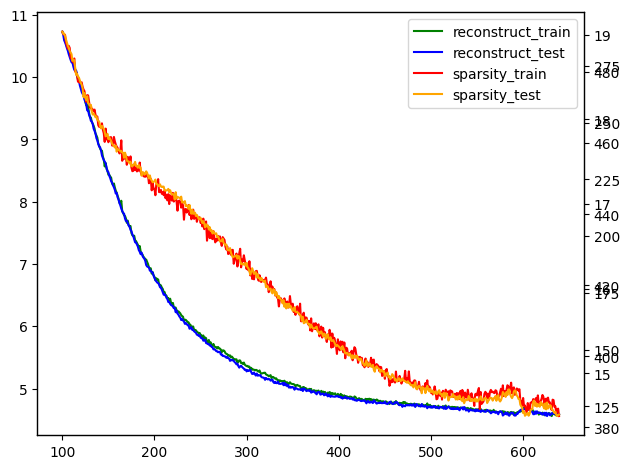

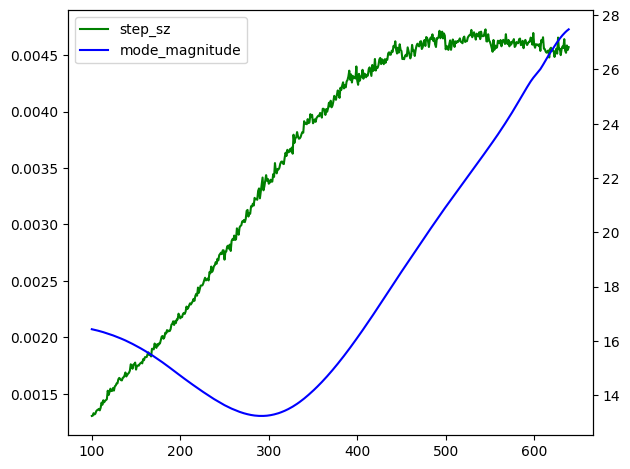

 36%|███▌      | 16998/47027 [26:12<35:51, 13.96it/s]  

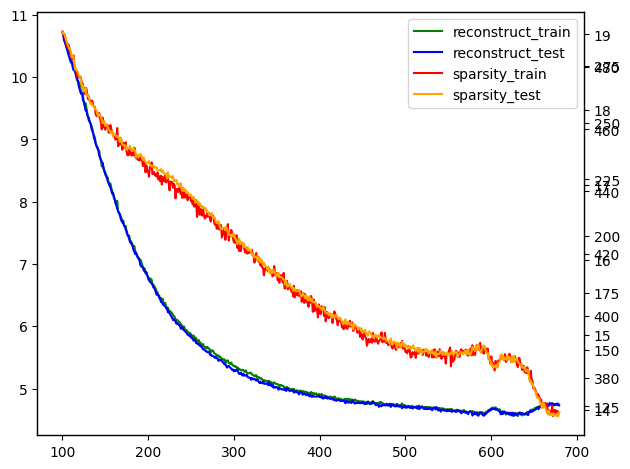

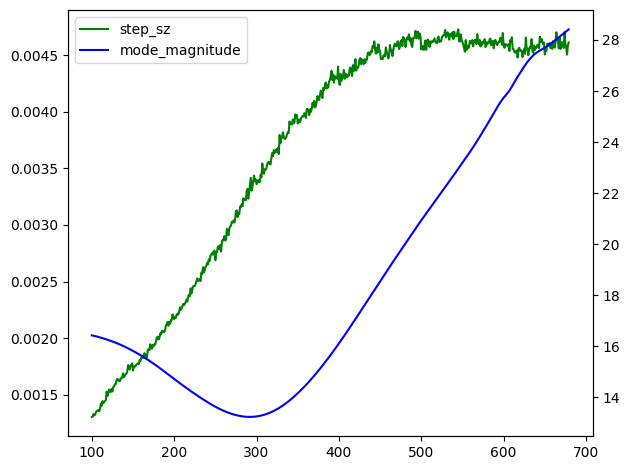

 38%|███▊      | 17998/47027 [27:45<34:29, 14.03it/s]  

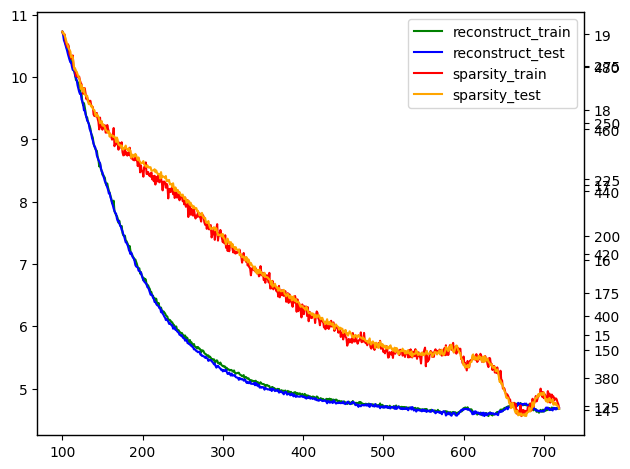

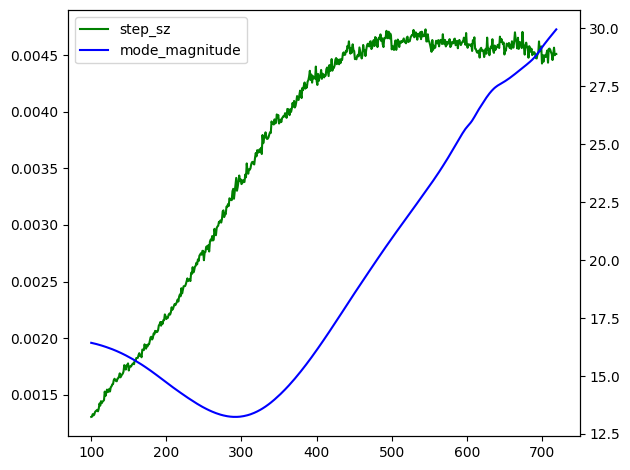

 40%|████      | 18998/47027 [29:17<33:11, 14.08it/s]  

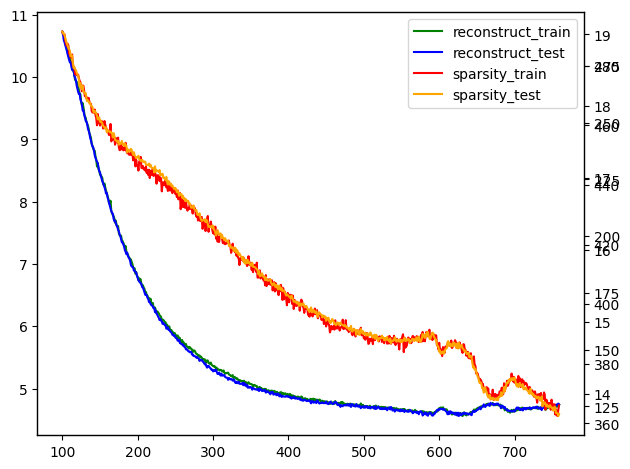

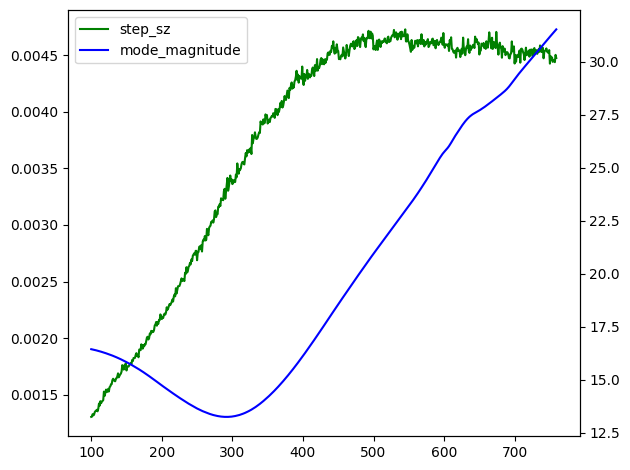

 43%|████▎     | 19998/47027 [30:50<32:08, 14.02it/s]  

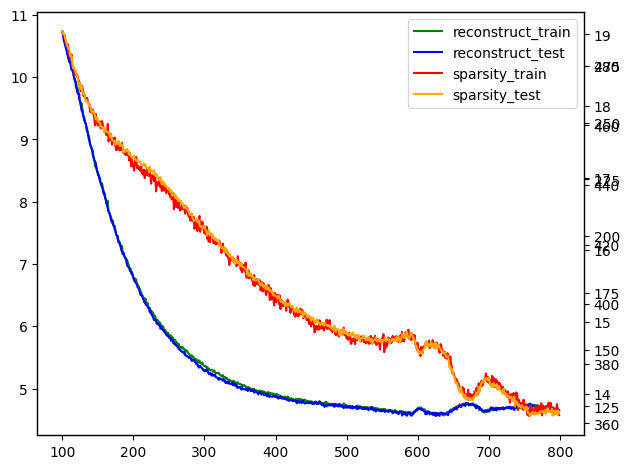

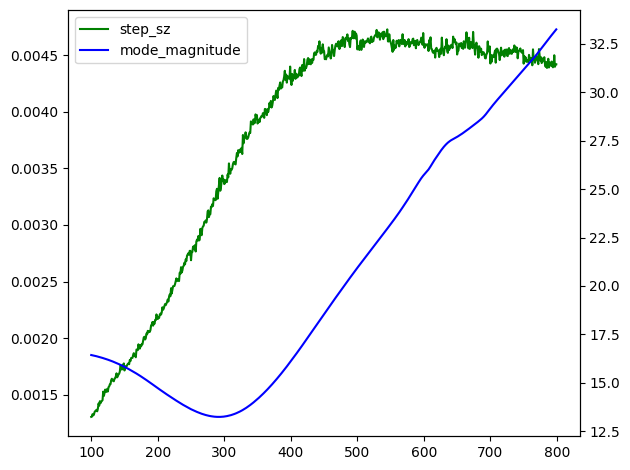

 45%|████▍     | 20998/47027 [32:23<31:02, 13.98it/s]  

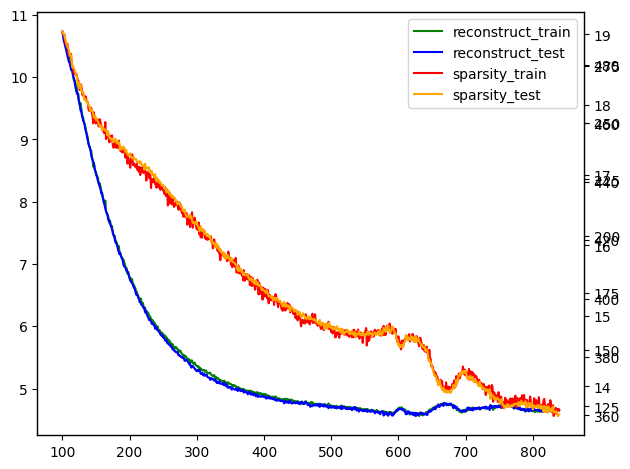

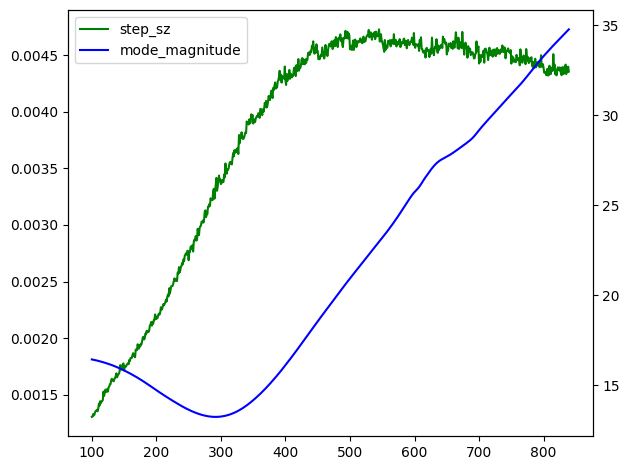

 47%|████▋     | 21998/47027 [33:56<29:51, 13.97it/s]  

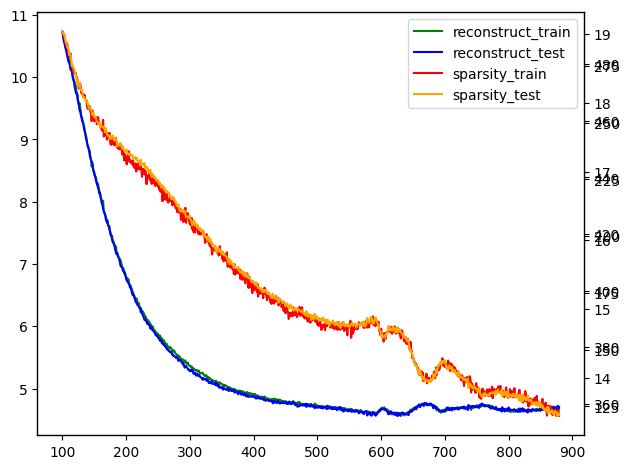

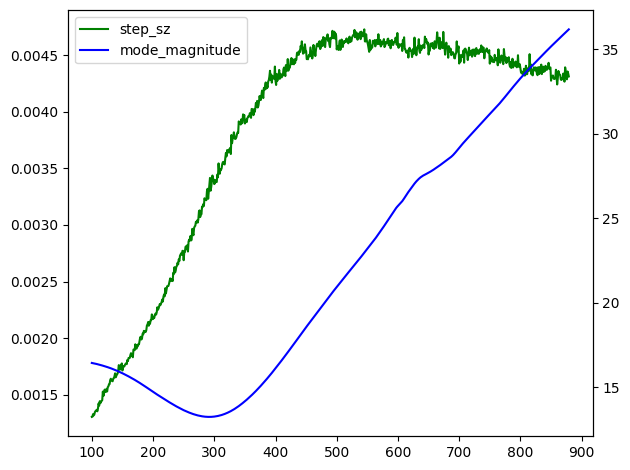

 49%|████▉     | 22998/47027 [35:28<28:50, 13.89it/s]  

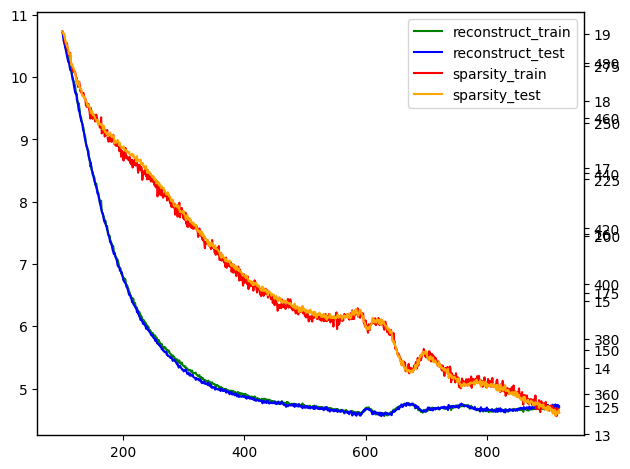

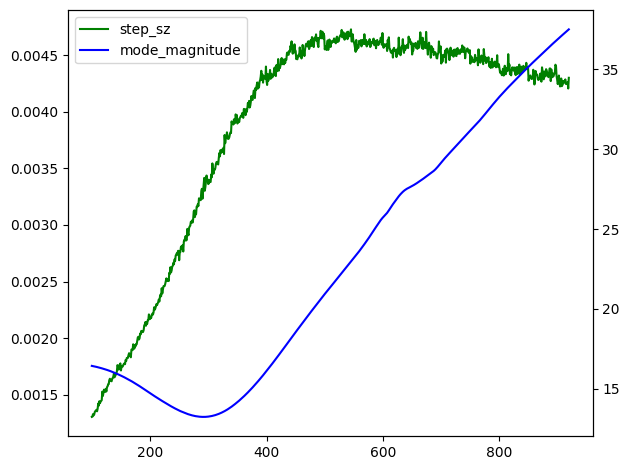

 51%|█████     | 23998/47027 [37:01<27:30, 13.96it/s]  

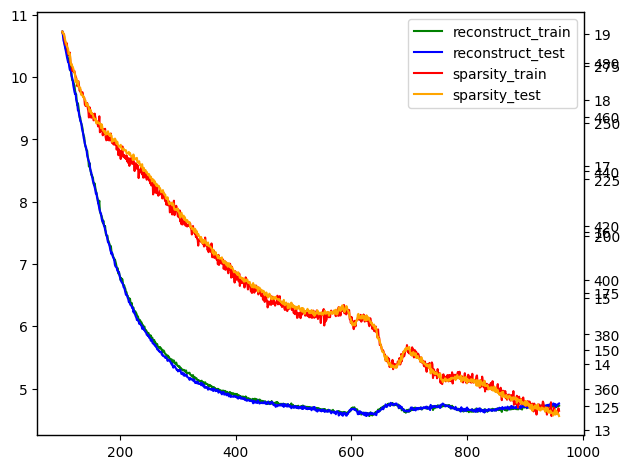

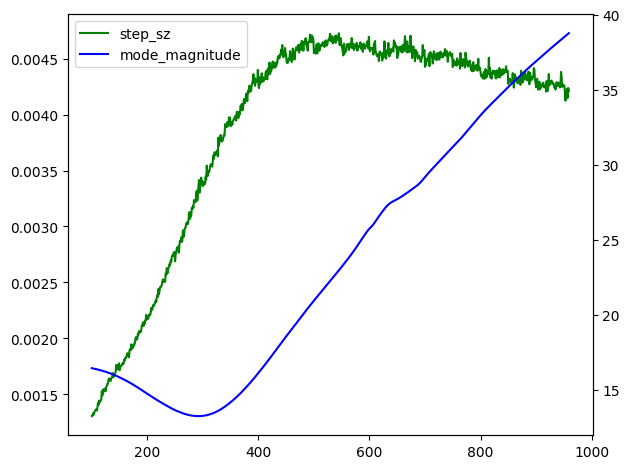

 53%|█████▎    | 24998/47027 [38:33<26:10, 14.03it/s]  

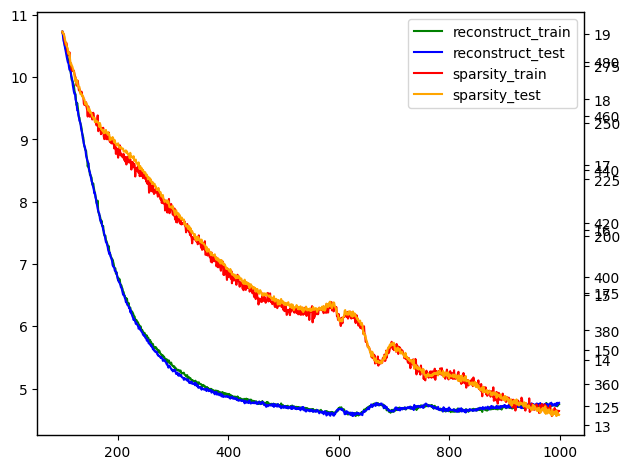

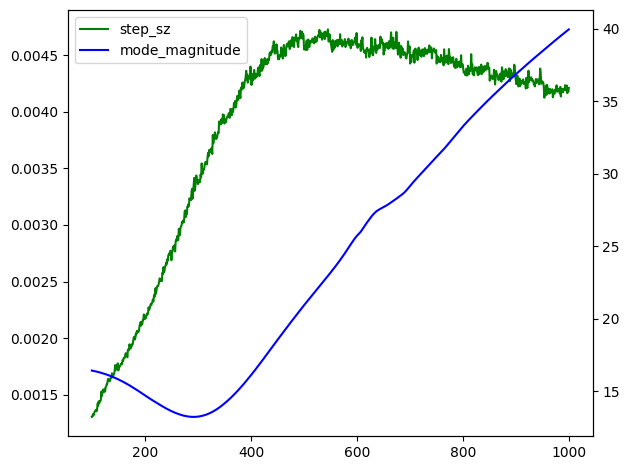

 55%|█████▌    | 25998/47027 [40:06<24:57, 14.04it/s]  

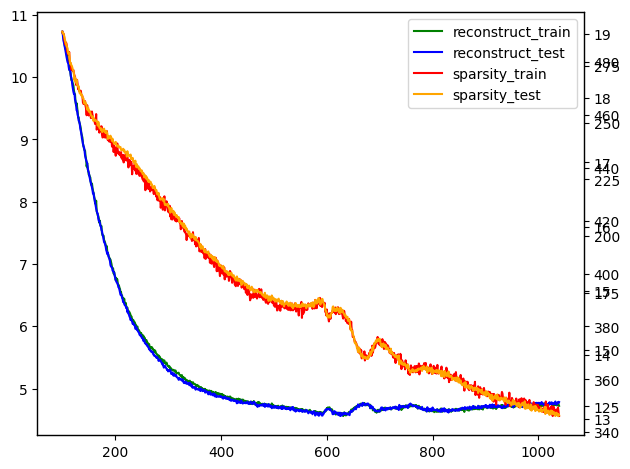

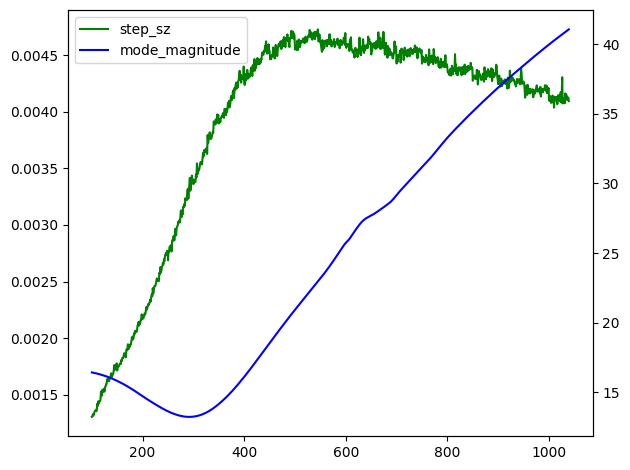

 57%|█████▋    | 26998/47027 [41:38<23:38, 14.12it/s]  

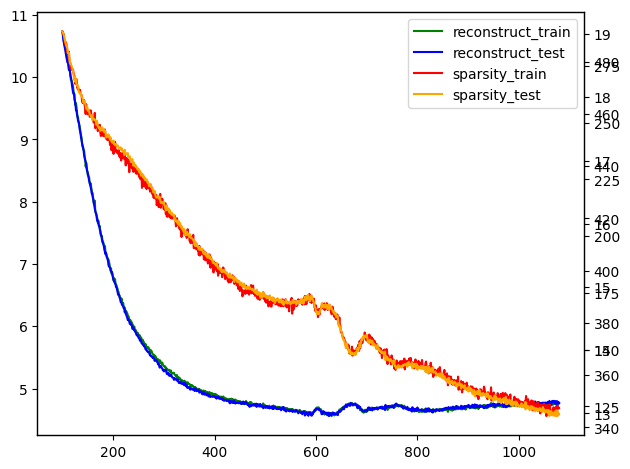

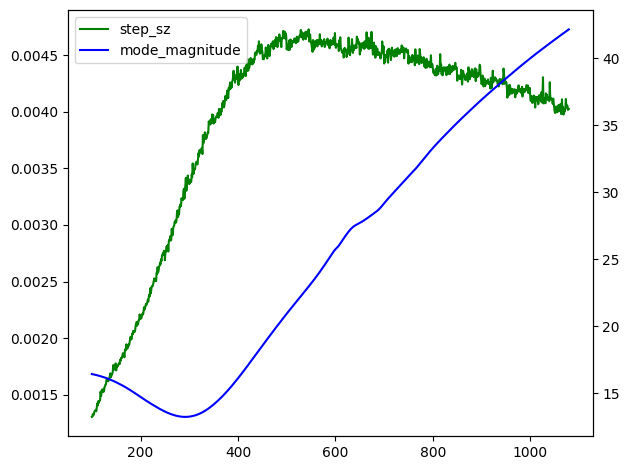

 60%|█████▉    | 27998/47027 [43:11<22:42, 13.96it/s]  

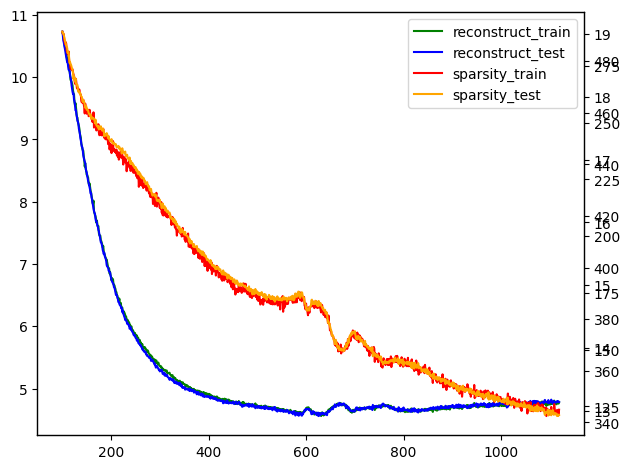

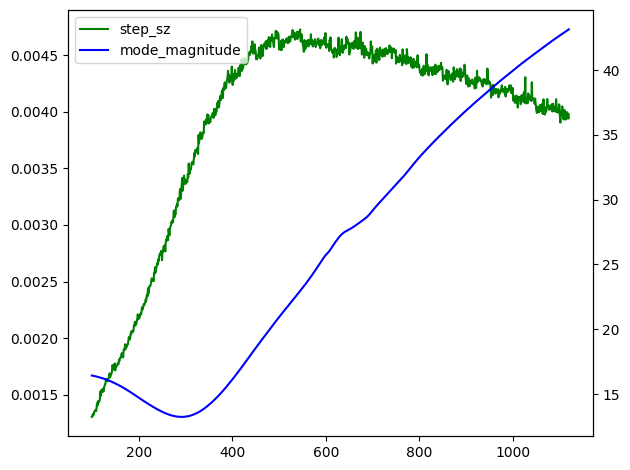

 62%|██████▏   | 28998/47027 [44:45<21:39, 13.88it/s]  

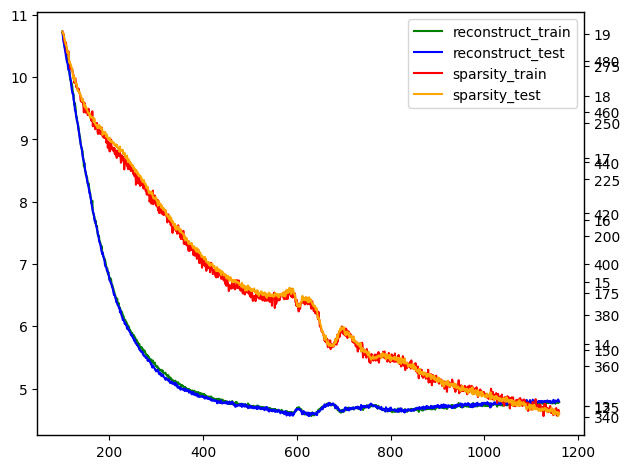

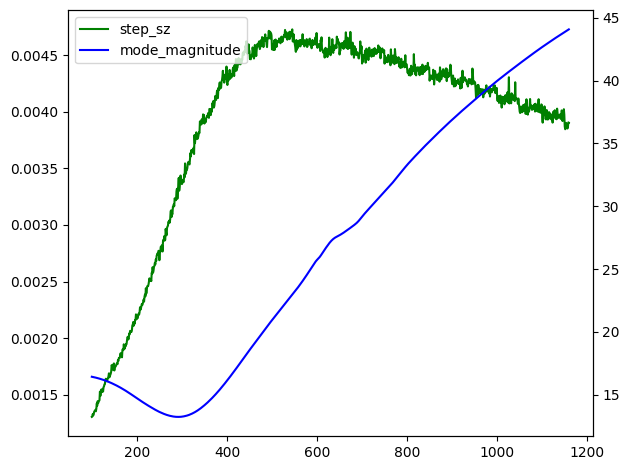

 64%|██████▍   | 29998/47027 [46:18<20:23, 13.91it/s]  

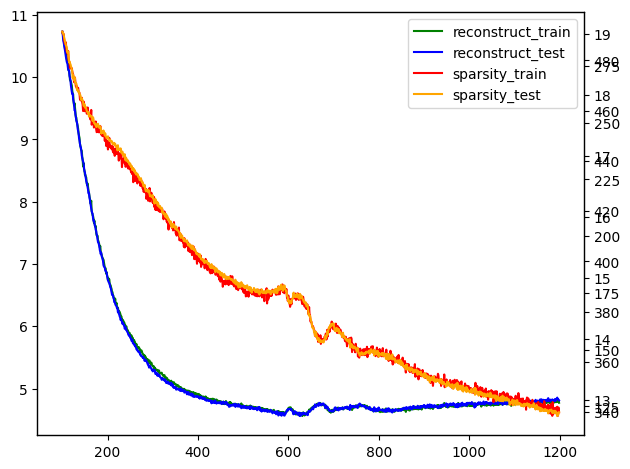

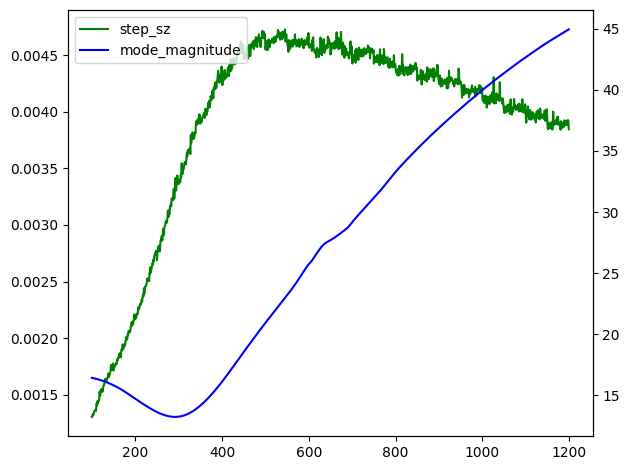

 66%|██████▌   | 30998/47027 [47:51<19:15, 13.87it/s]  

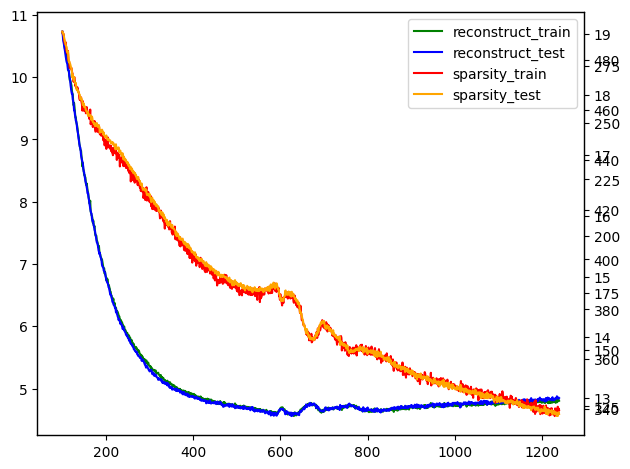

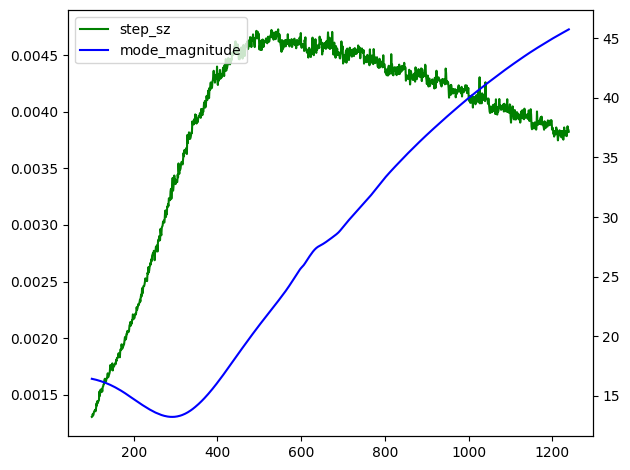

 68%|██████▊   | 31998/47027 [49:24<17:55, 13.98it/s]  

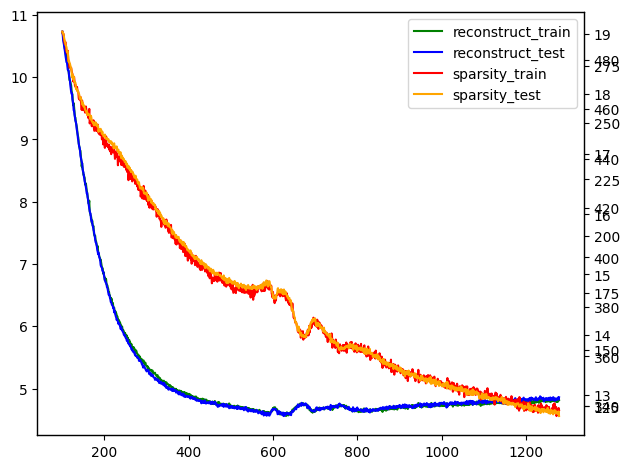

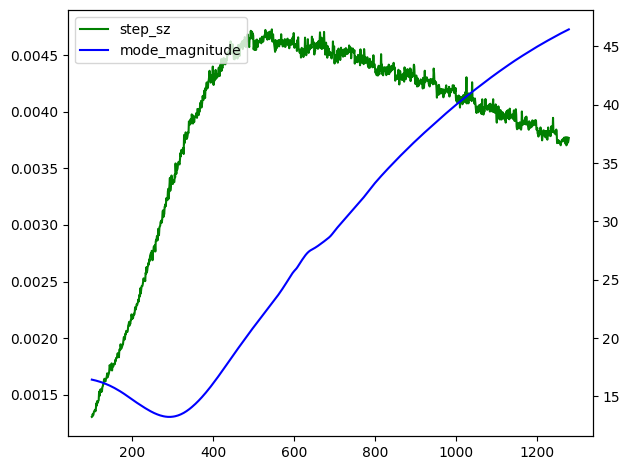

 70%|███████   | 32998/47027 [50:56<16:44, 13.96it/s]  

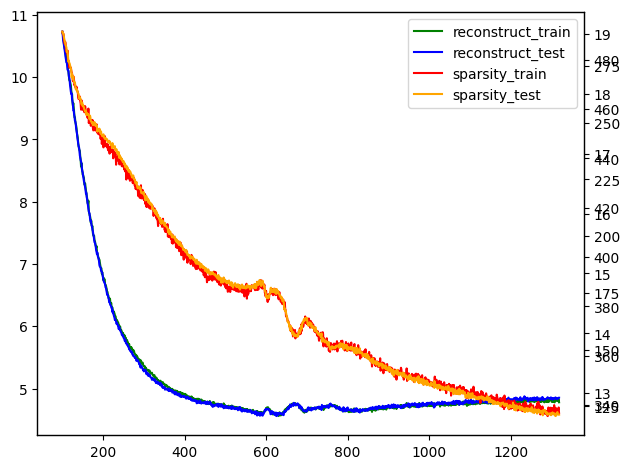

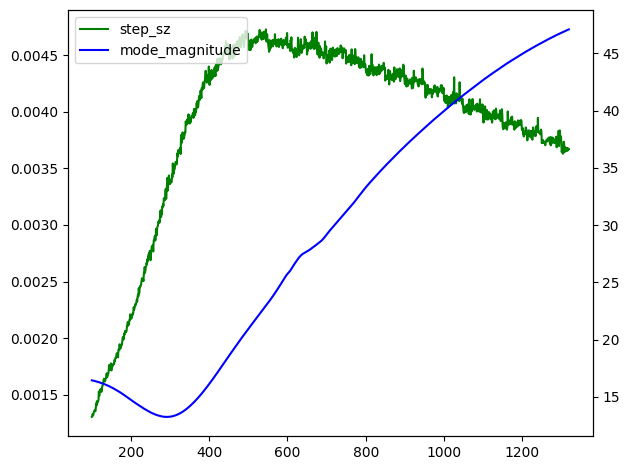

 72%|███████▏  | 33998/47027 [52:29<15:31, 13.99it/s]  

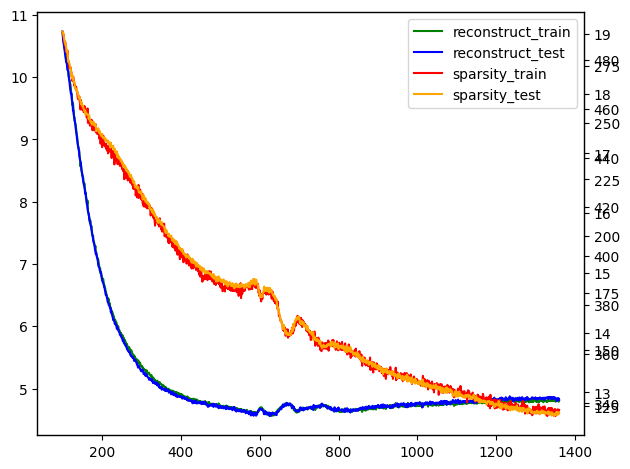

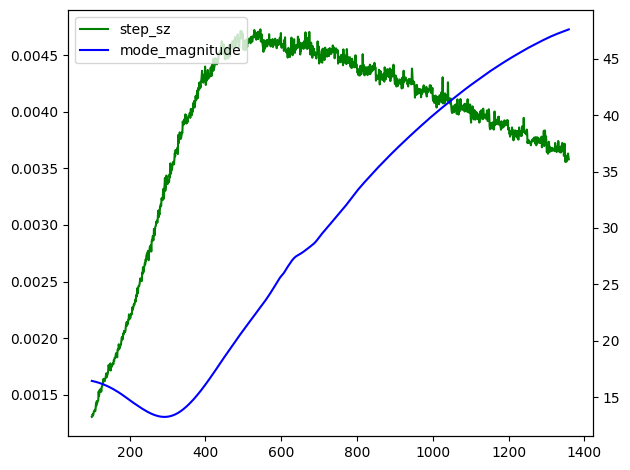

 74%|███████▍  | 34998/47027 [54:02<14:19, 13.99it/s]  

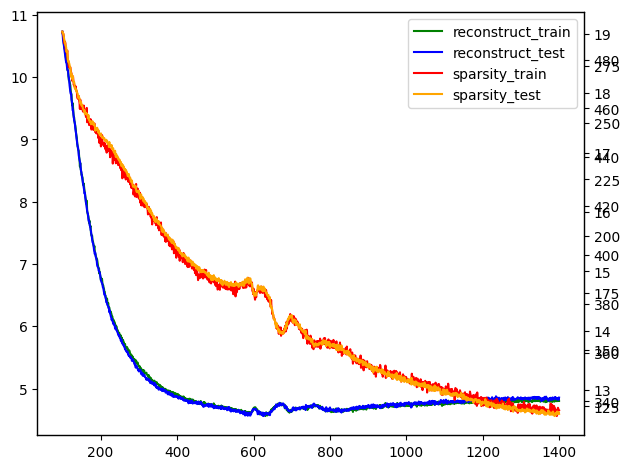

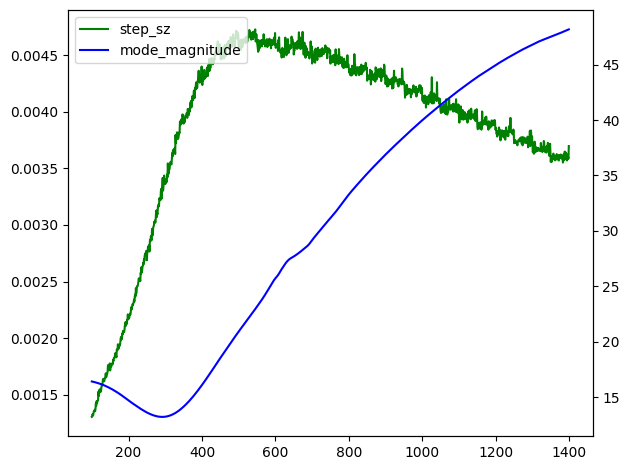

 77%|███████▋  | 35998/47027 [55:34<13:09, 13.97it/s]  

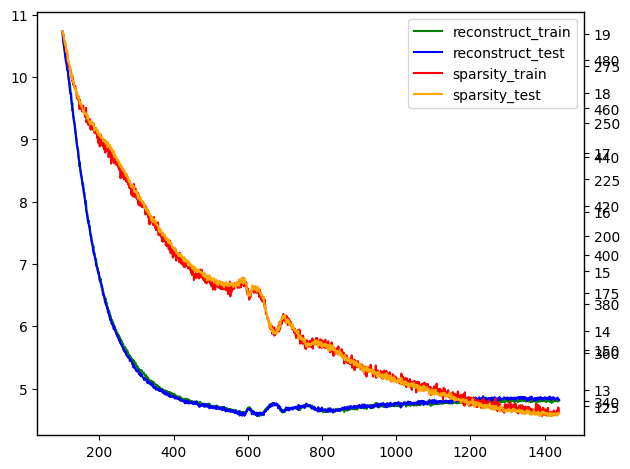

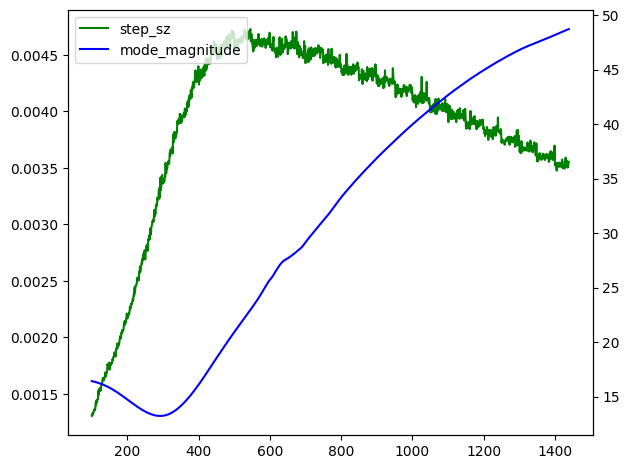

 79%|███████▊  | 36998/47027 [57:08<11:59, 13.94it/s]  

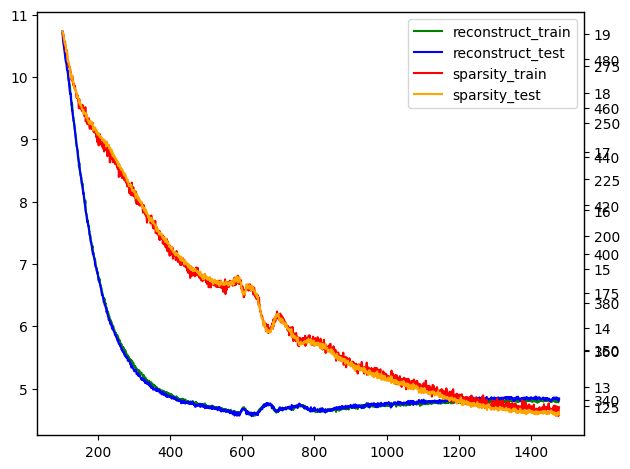

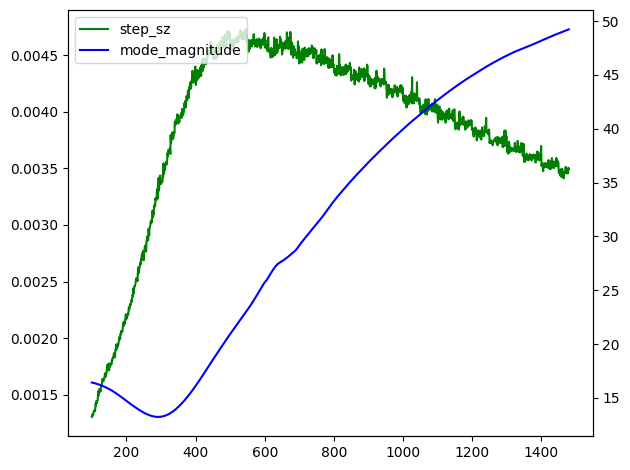

 81%|████████  | 37998/47027 [58:40<10:44, 14.01it/s]

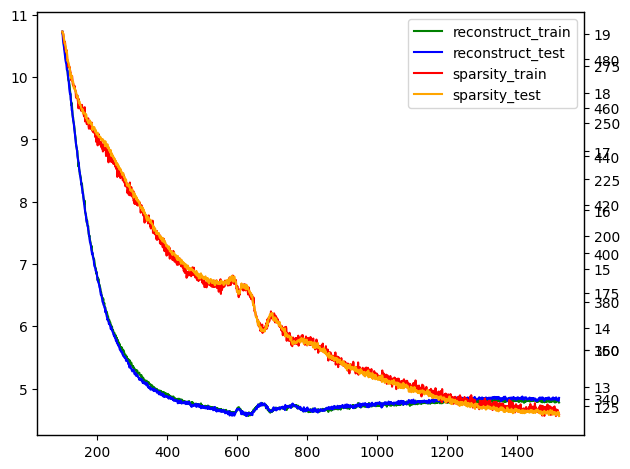

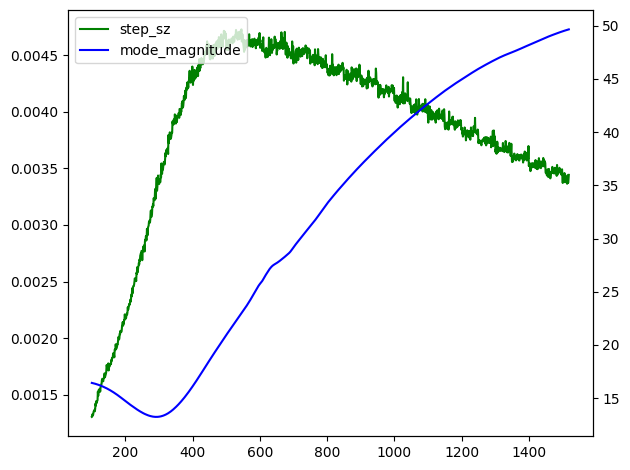

 83%|████████▎ | 38998/47027 [1:00:13<09:32, 14.04it/s]

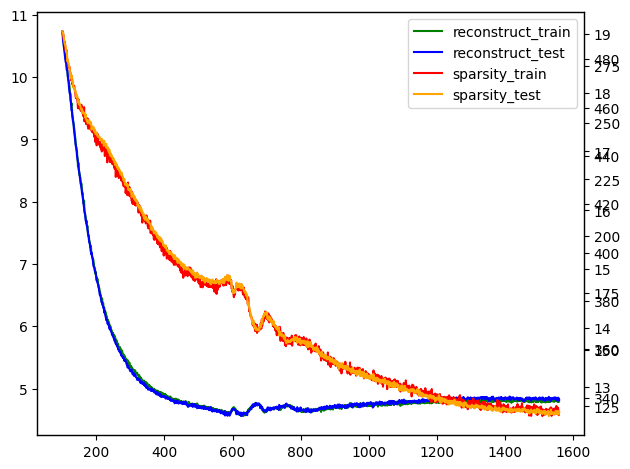

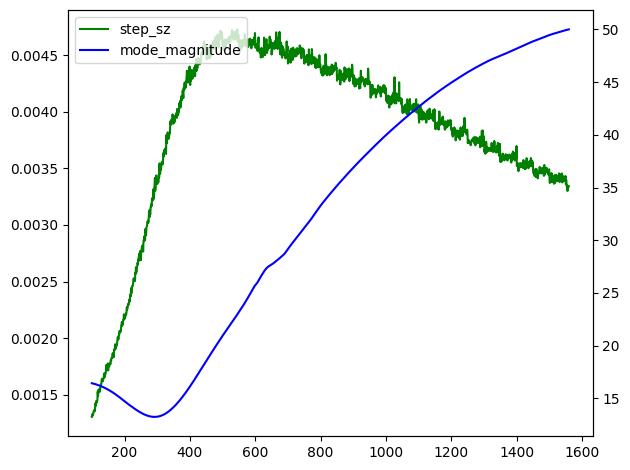

 85%|████████▌ | 39998/47027 [1:01:46<08:18, 14.09it/s]

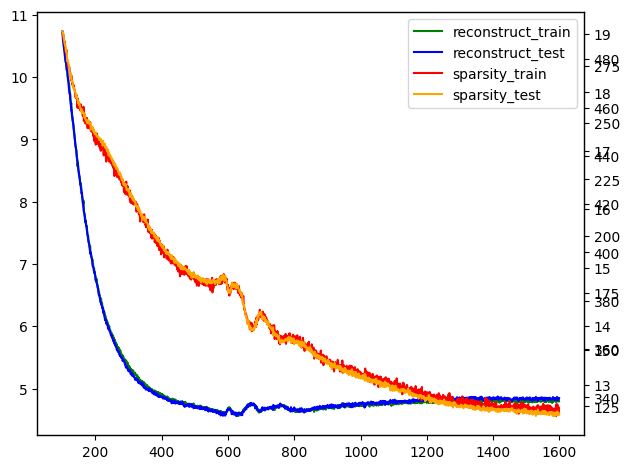

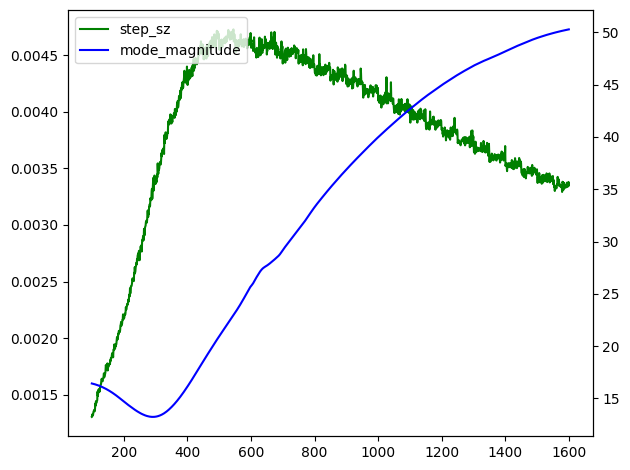

 87%|████████▋ | 40998/47027 [1:03:19<07:09, 14.03it/s]

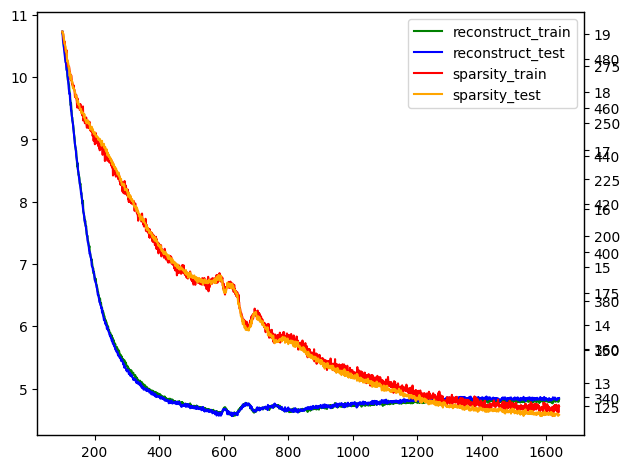

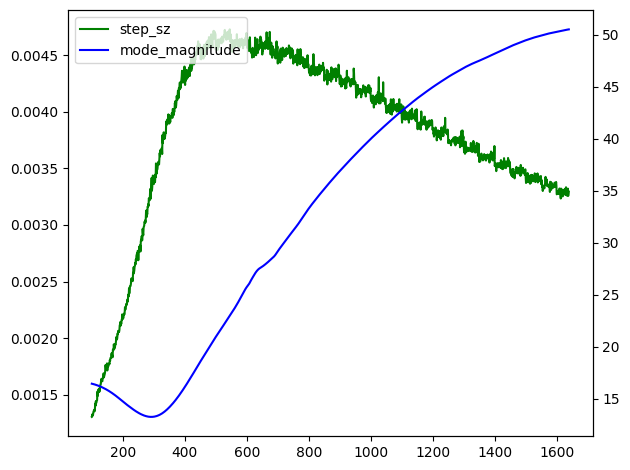

 89%|████████▉ | 41998/47027 [1:04:51<05:57, 14.08it/s]

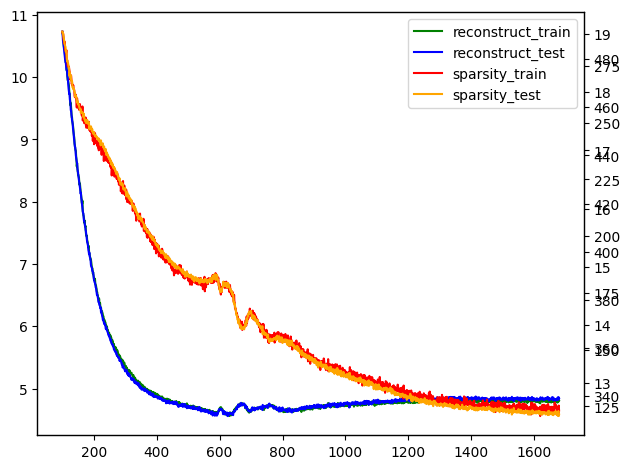

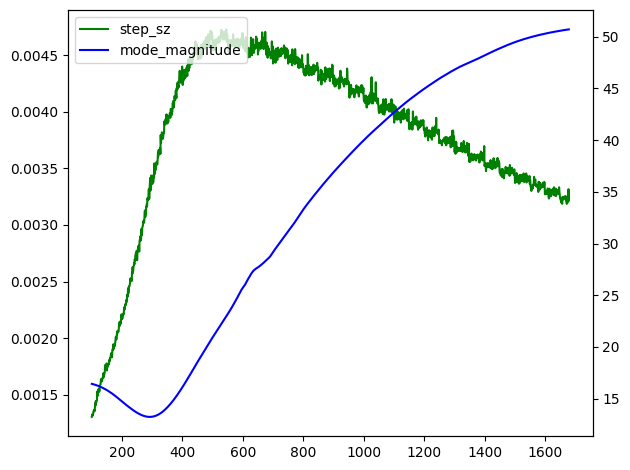

 91%|█████████▏| 42998/47027 [1:06:24<04:47, 14.02it/s]

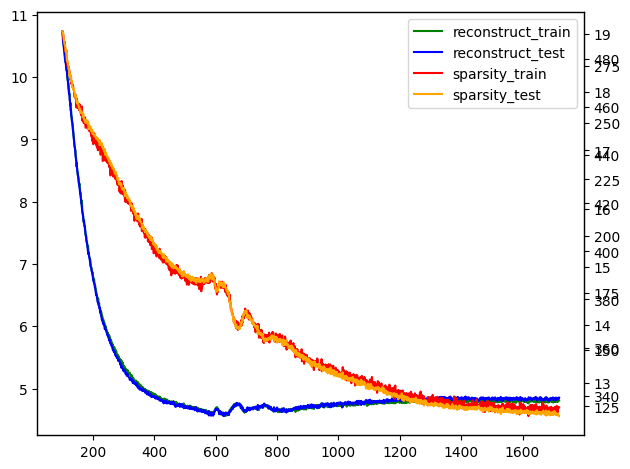

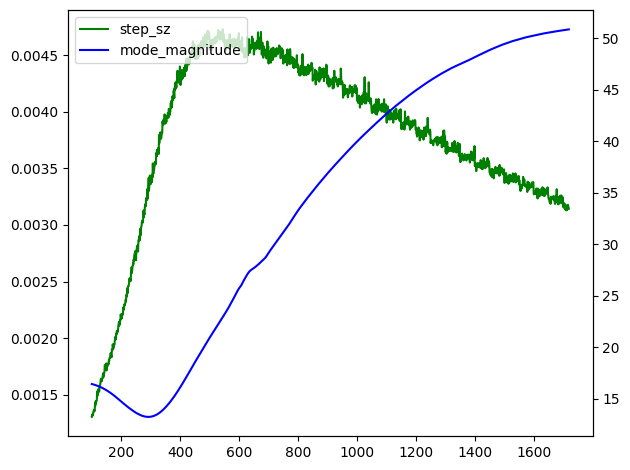

 94%|█████████▎| 43998/47027 [1:07:58<03:37, 13.92it/s]

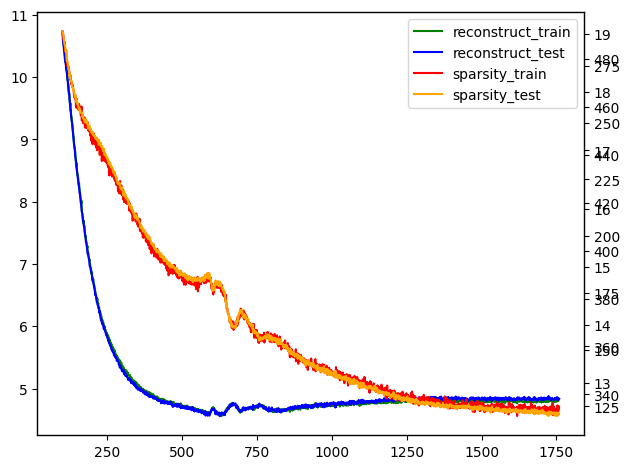

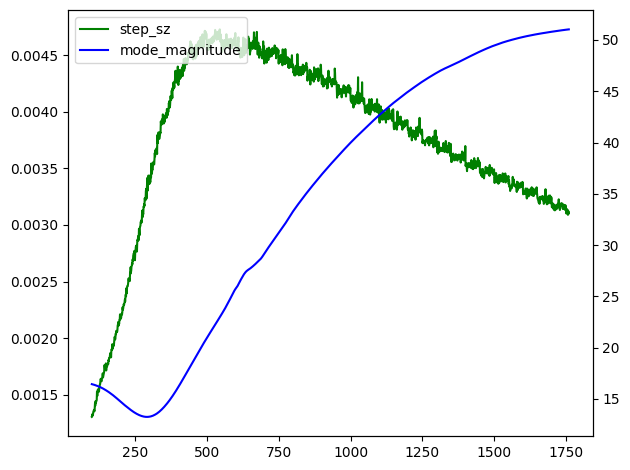

 96%|█████████▌| 44998/47027 [1:09:31<02:25, 13.95it/s]

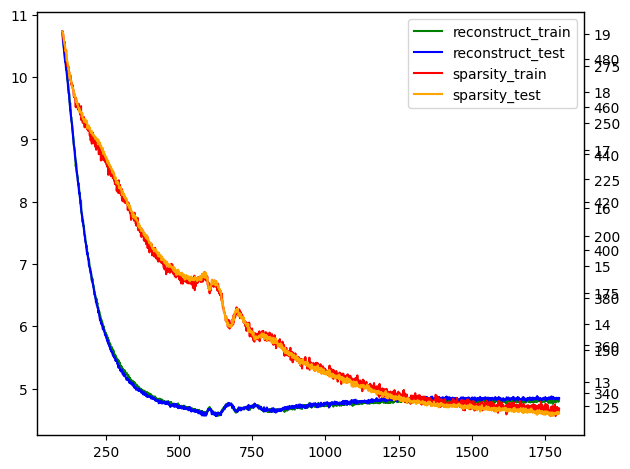

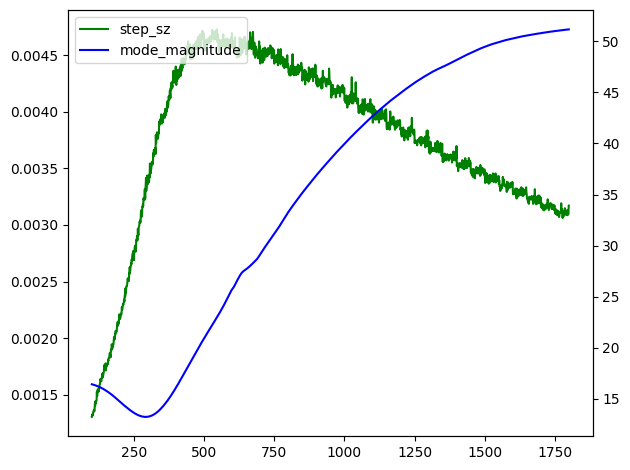

 98%|█████████▊| 45998/47027 [1:11:04<01:14, 13.90it/s]

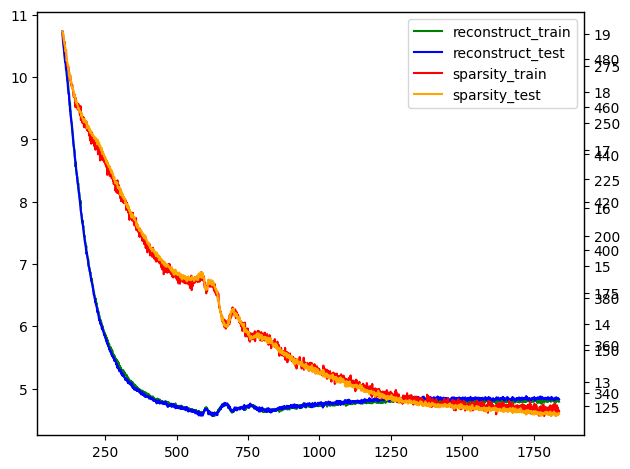

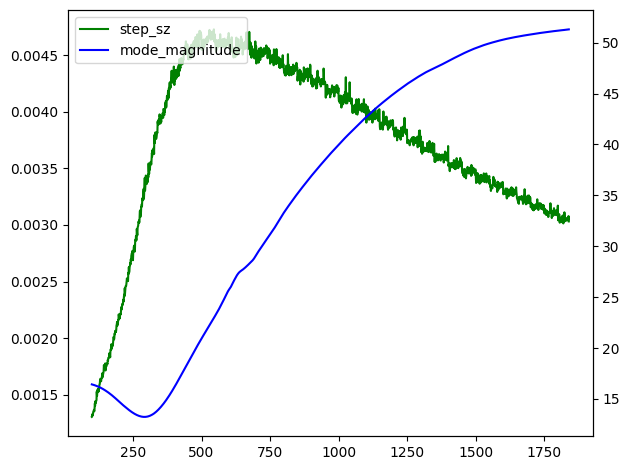

100%|█████████▉| 46998/47027 [1:12:37<00:02, 14.00it/s]

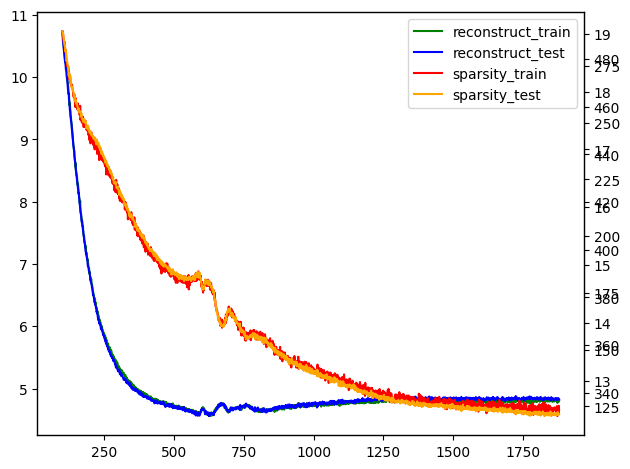

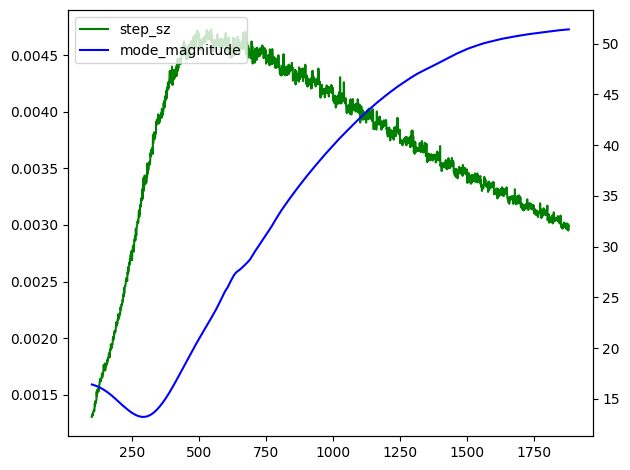

100%|██████████| 47027/47027 [1:12:41<00:00, 10.78it/s]


In [7]:
# From Ed: not sure if the training_utils.py in the two repos are the same so replicated the directory format exactly.
# also copied data.py from taskdiscovery

# %%
import torch
import torch as t
from transformer_lens import HookedTransformer
from encoders import TiedEncoder
import numpy as np 
from tqdm import tqdm
from fancy_einsum import einsum
from einops import rearrange
from itertools import islice
import math
from functools import partial
import torch.optim
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from training_utils import load_model_data, save_hook_last_token, ablation_hook_last_token, LinePlot

import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# %%

model_name = "gpt2-small"
batch_size = 100
ctx_length = 25
# changed to smaller dataset
device, model, tokenizer, owt_loader = load_model_data(model_name, batch_size, ctx_length, ds_name="Elriggs/openwebtext-100k", repeats=False)

test_batch_size = 1000
test_ds = torch.utils.data.Subset(owt_loader.dataset,range(200000, 250000))
test_batch = test_ds[:test_batch_size]['tokens'].to(device)

model.eval()

# %%
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_dim = model.cfg.d_head
d_model = model.cfg.d_model
print(n_layers, n_heads, head_dim, d_model)

# inverse probe setting
layer_no = 3
pca_dimension = 400
activation_dim = 768
lr=1e-4

intervene_filter = lambda name: name == f"blocks.{layer_no}.hook_resid_post"

# %%

def retrieve_activation_hook(activation_storage, act, hook):
    activation_storage.append(act)

# %%
    
feature_dim = 3000
activation_dim = 768
j = 0

sae = TiedEncoder(feature_dim, activation_dim).to(device)
# sae.load_state_dict(torch.load(f"SAE_training/epoch_{j}.pt"))


# %%
lr = 1e-3
optimizer = torch.optim.Adam(sae.parameters(), lr=lr, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.98)
# %%

def ev_batch(batch):
    activation_storage = []
    with torch.no_grad():
        model.run_with_hooks(
            batch,
            fwd_hooks=[(intervene_filter, 
                        partial(retrieve_activation_hook,
                                activation_storage
                        ))],
            stop_at_layer=(layer_no+1)
        )
    x = activation_storage[0][:,1:].flatten(0,1)
    # start_batch = i * int(x.shape[0]/5)
    # end_batch = (i +1)* int(x.shape[0]/5)
    recovery, l1, l2 = sae(x)
    loss = (recovery - x).square().sum()
    return loss, l1

# %%

running_loss = [0,0]
record_freq = 25

lp = LinePlot(['reconstruct_train', 'reconstruct_test', 'sparsity_train', 'sparsity_test'])

lp_2 = LinePlot(['step_sz', 'mode_magnitude'])
# test_iter = islice(owt_iter,200000,250000)
test_samples_per_reading = (ctx_length - 1) * test_batch_size
train_samples_per_reading = record_freq * (ctx_length - 1) * batch_size

directory_path = "SAE_training/SAE_rerun_tied"
os.makedirs(directory_path, exist_ok=True)

# %%
for i,batch in enumerate(tqdm(iter(owt_loader))):
    batch = batch['tokens'].to(device)
    optimizer.zero_grad()
    loss, l1 = ev_batch(batch)
    running_loss[0] += loss.item() / train_samples_per_reading
    running_loss[1] += l1.item() / train_samples_per_reading
    loss += .7*l1
    # recovery, l1, l2 = sae(x[start_batch:end_batch])
    # loss = (recovery - x[start_batch:end_batch]).square().sum() + l1
    
    loss.backward()

    if i % (-1 * record_freq) == -1:
        prev_weights = sae.feature_weights.clone().detach()
 
        optimizer.step()
        step_sz = (sae.feature_weights.detach() - prev_weights).norm(dim=-1).mean()

        test_loss, test_l1 = ev_batch(test_batch)

        lp.add_entry({ 
            'reconstruct_train': running_loss[0] / record_freq, 
            'reconstruct_test': test_loss.item() / test_samples_per_reading,'sparsity_train': running_loss[1] / record_freq,
            'sparsity_test': test_l1.item() / test_samples_per_reading, 
        })
        lp_2.add_entry({
            'step_sz': step_sz.item(), 
            'mode_magnitude': sae.floating_mean.norm().item() 
        })
        # print(running_loss)
        running_loss = [0,0]
        scheduler.step()
    else:
        optimizer.step()

    sae.feature_weights.data /= sae.feature_weights.data.norm(dim=-1, keepdim=True)

    if i % -1000 == -1:
        torch.save(sae.state_dict(),f"SAE_training/SAE_rerun_tied/epoch_{j}.pt")
        lp.plot(start= min(lp.t // 2,100), save=f"SAE_training/SAE_rerun_tied/epoch_{j}.png")
        lp_2.plot(save=f"SAE_training/SAE_rerun_tied/epoch_{j}_plot2.png")
        j += 1

# activation training starting from SAE initialization
# try to fix PCA training
# SAE on the model weights
# in particular this thing is fast
# %%


In [8]:
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_dim = model.cfg.d_head
d_model = model.cfg.d_model
print(n_layers, n_heads, head_dim, d_model)

12 12 64 768
